# Import

In [1]:
import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt
# from blockeval.analysis import *
# from blockeval.utils import campaign_simulation

In [49]:
# style
from matplotlib import style
style.use("ggplot")
pd.options.display.float_format = '{:.4f}'.format

# Uplift Campaign Analysis

In this simulation, we have 2 business segments, Public and Private, and 2 personas, Refractory and Persuadable, thus making up 4 blocks. The personas come from a hypothetical uplift model. The 2 Persuadable blocks have an ATE of 4 percentage points (pp) and the Refractory ones have no treatment effect with an ATE of 0pp. Within each block, customers are randomized into a Treated and a Control group:

![UpliftDesign](figures/UpliftDesign.PNG)

To optimize Return-On-Investment (ROI), the proportion of customers assigned to the treatment is higher in the Persuadable blocks (80%) compared to the Refractory ones (20%). In this simulated campaign, the outcome is binary, 1 for the customers who subscribed to a service, 0 otherwise.

## Data simulation

The outcomes of 100,000 customers are simulated for the 4 blocks presented in the figure above. The blocks have the same sample size, but the treatment probabilities and the treatment effects are higher in the 'public_persuadable' and 'private_persuadable' blocks:

In [7]:
uplift_data = campaign_simulation(blocks = ['public_refractory', 'public_persuadable', 'private_refractory', 'private_persuadable'],
        block_sizes = [100000,  100000, 100000, 100000],
        treatment_probas = [0.5,  0.8, 0.5, 0.8],
        control_means = [0.15, 0.15, 0.15, 0.15],
        treatment_effects = [0, 0.04, 0, 0.04])

The 'segment' and 'persona' columns are then derived from the blocks. To control how the results will be displayed, these new columns are converted to ordered categorical variables. The first category of the segment ('public') and persona ('refractory') will be used as the reference level when comparing groups:

In [8]:
uplift_data['segment'] = np.where(uplift_data['block'].str.contains('public'), 'public', 'private')
uplift_data['segment'] = pd.Categorical(uplift_data['segment'], categories=['public', 'private'], ordered=True)
uplift_data['persona'] = np.where(uplift_data['block'].str.contains('refractory'), 'refractory', 'persuadable')
uplift_data['persona'] = pd.Categorical(uplift_data['persona'], categories=['refractory', 'persuadable'], ordered=True)

Below is an extract of the campaign data. The 'treatment' indicator is set to 1 for the Treated group and to 0 otherwise:

In [9]:
uplift_data.head()

,outcome,treatment,block,segment,persona
0,0,1,public_refractory,public,refractory
1,1,1,public_refractory,public,refractory
2,0,1,public_refractory,public,refractory
3,0,1,public_refractory,public,refractory
4,0,1,public_refractory,public,refractory


## Simple Mean Comparison

When calculating the means, we see that the outcome is higher in the Treated group (17.50%) compared to the Control group (14.91%). The difference gives an overall ATE of 2.58pp:

In [10]:
s = uplift_data.groupby('treatment')['outcome'].mean()
df = pd.DataFrame(s.append(s.diff()[[1]])).reset_index(drop=True).transpose()
df.columns = ['control', 'treated', 'difference']
df

,control,treated,difference
outcome,0.1491,0.1750,0.0258


The observed 2.58pp difference is higher than the expected 2pp ATE, but without a confidence interval, it is difficult to judge if the estimation is biased or not.

## Regressions Give Conflicting Results

The second approach to estimate the ATE is to fit a regression to the entire campaign and include the treatment indicator as an independent variable:

In [11]:
# treatment only
regression = smf.ols('outcome ~ treatment', data=uplift_data).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1491,0.001,150.063,0.000,0.147,0.151
treatment,0.0258,0.001,20.971,0.000,0.023,0.028


The regression gives an ATE of 2.58pp, the same as the simple mean comparison. The 95% CI of [2.3pp, 2.8pp] does not include the true ATE of 2pp. Thus, the simple mean comparison and the regression overestimate the ATE.

 In an attempt to control for the confounding persona, the 'block' is added as a covariate in the regression:

In [12]:
# include blocks
regression_block = smf.ols('outcome ~ treatment + C(block)', data=uplift_data).fit()
regression_block.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1404,0.001,104.594,0.000,0.138,0.143
C(block)[T.public_persuadable],0.0295,0.002,17.310,0.000,0.026,0.033
C(block)[T.private_refractory],0.0020,0.002,1.222,0.222,-0.001,0.005
C(block)[T.private_persuadable],0.0264,0.002,15.488,0.000,0.023,0.030
treatment,0.0170,0.001,13.066,0.000,0.014,0.019


This time, the regression underestimates the ATE with a value of 1.7pp and a 95% CI of [1.4, 1.9].

## Block Summary

To see if we can recover the true 2pp ATE, we first calculate the ATE conditioned by the blocks. The get_block_summary() function was written to facilitate these calculations. The 'keep_cols' argument is used to keep information about the segment and the persona in the summary which will be useful later for group comparisons:

In [13]:
block_summary(uplift_data, keep_cols=['segment', 'persona'])

,block,segment,persona,eff,treated_mean,control_mean,treated_size,control_size,block_size,treatment_proba
0,public_refractory,public,refractory,0.0005,0.1491,0.1486,50000,50000,100000,0.5000
1,public_persuadable,public,persuadable,0.0397,0.1914,0.1517,80000,20000,100000,0.8000
2,private_refractory,private,refractory,0.0026,0.1522,0.1496,50000,50000,100000,0.5000
3,private_persuadable,private,persuadable,0.0424,0.1889,0.1465,80000,20000,100000,0.8000


We can see from the 'eff' column that the ATEs are close to 4pp in the 2 Persuadable blocks and close to 0pp in the Refractory ones. The 4 blocks have the same size (100,000) and the treatment probability is higher in the Persuadable blocks (80% vs 50%). Thus, the summary matches the parameters used for the simulation (see Figure above).

## Weighted Average Treatment Effect

The overall treatment effect we are looking for is the weighted average between the Persuadable and Refractory ATEs (4pp and 0pp). In our case, it is simply the average (2pp) because the blocks were given equal size to simplify the example. To estimate the Weighted ATE we wrote a function that takes the campaign data as input. By default, the function uses the block sizes as the weights:

In [14]:
weighted_avg_test(uplift_data)

,group,eff,treated_mean,control_mean,treated_size,control_size,group_size,eff_se,z,p_value,ci_low,ci_upp,incremental
0,all,0.0213,0.1704,0.1491,260000,140000,400000,0.0013,16.4690,0.0000,0.0188,0.0238,8515.0000


The estimated ATE in the 'eff' column is 2.13pp with a CI of [1.88, 2.38]. This time the CI includes the true underlying 2pp ATE. This confirms that the result of the weighted average approach is valid. The output also shows 8,515 'incremental' conversions which are obtained by multiplying the 'eff' by the 'group size'.

The group_by argument can be specified to calculate the Weighted ATE for groups of blocks. In this example, blocks are grouped by persona:

In [15]:
weighted_avg_test(uplift_data, group_by=['persona'])

,persona,eff,treated_mean,control_mean,treated_size,control_size,group_size,eff_se,z,p_value,ci_low,ci_upp,incremental
0,refractory,0.0015,0.1507,0.1491,100000,100000,200000,0.0016,0.9710,0.3316,-0.0016,0.0047,310.0000
1,persuadable,0.0410,0.1901,0.1491,160000,40000,200000,0.0020,20.1758,0.0000,0.0370,0.0450,8205.0000


For the Refractory persona, the Weighted ATE is 0.15pp with a 95% CI of [-0.16, 0.47] which includes the true underlying value of 0. For the Persuadable persona, it is 4.10pp with a 95% CI of [3.70, 4.50] which include the true underlying value of 4pp.

## Comparing Effects Between Groups

The last results showed how to calculate the treatment effect after pooling blocks into groups. We now show how to compare the treatment effect between groups of blocks, for example Persuadable vs Refractory blocks. The function comparison_test() with the argument compare_along='persona' calculates the Weighted ATE difference between the Persuadable and Refractory blocks:

In [16]:
comparison_test(uplift_data, compare_along='persona')

,eff_delta,variant_grp,reference_grp,variant_size,reference_size,eff_se,z,p_value,ci_low,ci_upp
0,0.0395,persuadable,refractory,200000,200000,0.0026,15.2699,0.0000,0.0344,0.0445


The result shows a difference of 3.95pp ('eff_delta') with a 95% CI of [3.44pp, 4.45pp]. This CI includes the expected difference of 4pp. Overall using the Weighted ATE allows data scientists to compare the treatment effect between any blocks or any group of blocks.

## Bootstrapping and Permutation Tests

For campaigns with small sample size (n < 30 for the Treated or Control groups within blocks), skewed outcomes, and/or outliers, we provide functions to bootstrap the Weighted ATE and do a permutation test. In this example, the campaign data is resampled 2,000 times and blocks are grouped by personas to get the Persuadable and Refractory treatment effects (this cell takes a few minutes to run):

In [17]:
# weighted average treatment effect
weighted_avg_bootstrap(uplift_data, group_by=['persona'], n_bootstrap=2000)

,eff,ci_low,ci_upp,p_value
persona,,,,
refractory,0.0015,-0.0016,0.0046,0.3280
persuadable,0.0410,0.0371,0.0448,0.0000


The estimates and confidence intervals are very close to the results of the weighted_average_test() function that calculates CI and p-value with mathematical formulas.

Bootstrapping can also be used to compare group of blocks (this cell takes a few minutes to run):

In [18]:
# group comparison
comparison_bootstrap(uplift_data, compare_along='persona', n_bootstrap=2000)

,eff_delta,variant_grp,reference_grp,p_value,ci_low,ci_upp
0,0.0395,persuadable,refractory,0.0000,0.0347,0.0445


Results are very close to the output of comparison_test(). For small sample size and/or skewed outcome distribution the results might differ, and it is recommended to use the bootstrapping functions.

## Using Other Weights

Because in reality the control group was not exposed to the treatment, another option is to calculate the conversations for the treatment group only. In this case, the ATE is multiplied by the Treated group size instead of the block size to get the incremental conversions. When calculating the Weighted ATE, the Treated group sizes are used as weights instead of the block sizes. This can be done by setting use_treated_weights=True in the weighted_average_test() function:

In [19]:
weighted_avg_test(uplift_data, use_treated_weights=True)

,group,eff,treated_mean,control_mean,treated_size,control_size,group_size,eff_se,z,p_value,ci_low,ci_upp,incremental
0,all,0.0258,0.1750,0.1491,260000,140000,400000,0.0014,18.5405,0.0000,0.0231,0.0286,6719.0000


The treatment effect is now 2.58pp compared to 2.13pp previously. The incremental conversions changed is now 6,719 compared to 8,515 previously (see section 'Weighted Average Treatment Effect'). The incremental number is much smaller because the treatment effect is multiplied by the Treated group instead of the block size (Treated + Control). The use_treated_weights option can also be set for the comparison_test() and bootstrap functions.

# Addressing the Simpson’s Paradox

In this example, a marketing team runs a survey and asks a random sample of men and women to say if they like a flavored drink or not (binary outcome). In the control group, participants are asked to taste a Passionate Peach drink. In the treatment group, they are asked to taste a Sinful Strawberry drink. The design of the survey is similar to a randomized block design:

![MarketingDesign.PNG](figures/MarketingDesign.PNG)

In this design, men have a higher probability to be assigned to the treatment group (56%) compared to women (25%). Thus, the block (gender) will act as a confounder. We first recreate the design in the figure above and generate random outcomes:

In [20]:
# simulate the data
marketing_data = campaign_simulation(blocks = ['men', 'women'], block_sizes = [1600,  400],
        treatment_probas = [900/1600,  100/400],
        control_means = [600/700, 150/300], treated_means = [760/900, 40/100])

The design is then summarized by block:

In [21]:
# summarizing the results
block_summary(marketing_data)

,block,eff,treated_mean,control_mean,treated_size,control_size,block_size,treatment_proba
0,men,-0.0025,0.8389,0.8414,900,700,1600,0.5625
1,women,-0.0933,0.4100,0.5033,100,300,400,0.2500


We can see that for both men and women the ATEs ('eff' column) are negative (-0.25pp and -9.33pp), meaning that participants give more favorable answers to the Peach flavor. Now we calculate the treatment effect with a regression and ignore gender:

In [22]:
# regression analysis
marketing_regression = smf.ols('outcome ~ treatment', data=marketing_data).fit()
marketing_regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7400,0.013,55.533,0.000,0.714,0.766
treatment,0.0560,0.019,2.972,0.003,0.019,0.093


The results show an overall positive ATE (+5.60pp) which contradicts the negative effects found within the blocks. The code below calculates the Weighted ATE:

In [23]:
# using the Weighted Average Approach
weighted_avg_test(marketing_data)

,group,eff,treated_mean,control_mean,treated_size,control_size,group_size,eff_se,z,p_value,ci_low,ci_upp,incremental
0,all,-0.0207,0.7531,0.7738,1000,1000,2000,0.0187,-1.1071,0.2683,-0.0573,0.0159,-41.3968


The Weighted ATE is -2.07pp, a result in line with the negative effects found separately in men and women. This example shows how the Weighted ATE can resolve Simpson's paradox.

# Other Evaluation Strategies

## Regression With Interaction Effect

Another approach to compare the treatment effect between blocks is to fit a regression with interactions between the treatment indicator and the blocks:

In [24]:
# including interaction effect
regression_interact = smf.ols('outcome ~ treatment * persona', data=uplift_data).fit()
regression_interact.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1491,0.001,126.932,0.000,0.147,0.151
persona[T.persuadable],1.5e-05,0.002,0.007,0.995,-0.004,0.004
treatment,0.0015,0.002,0.933,0.351,-0.002,0.005
treatment:persona[T.persuadable],0.0395,0.003,14.844,0.000,0.034,0.045


The ATE delta of 3.95pp with a 95% CI of [3.4pp, 4.5pp] is the same as the values found with the Weighted ATE approach (see section 'Comparing Effects Between Groups'). While regressions with interaction effects are helpful to compare groups, they don't directly provide the overall treatment effect. The Weighted ATE approach does provide the within groups, between groups, and overall treatment effects.

## Mixed Effect Regression

If the data scientists had randomly chosen the blocks from a larger set of segments and personas and if the goal was to generalize the campaign results to this larger set, a mixed-effect analysis would be the correct approach. This approach is illustrated below with a mixed-effect regression that allows for random fluctuation across the block intercepts and treatment effects:

In [25]:
mixed_model = smf.mixedlm('outcome ~ treatment', uplift_data, groups=uplift_data['block'], re_formula="treatment").fit()
mixed_model.summary()

/users/a091680/.conda/envs/boa_py_38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:             MixedLM   Dependent Variable:  outcome     
No. Observations:  400000    Method:              REML        
No. Groups:        4         Scale:               0.1380      
Min. group size:   100000    Log-Likelihood:      -171509.7703
Max. group size:   100000    Converged:           Yes         
Mean group size:   100000.0                                   
--------------------------------------------------------------
                      Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept             0.149    0.186 0.803 0.422 -0.215  0.513
treatment             0.021    0.186 0.115 0.909 -0.343  0.385
Group Var             0.138                                   
Group x treatment Cov 0.000                                   
treatment Var         0.138                                   
==============================================================

"""

In [26]:
uplift_data.groupby('treatment')['outcome'].mean()

treatment
0   0.1491
1   0.1750
Name: outcome, dtype: float64

The results show a treatment effect of 2.1pp with 95% CI of [-34.3pp, 38.5pp] CI (p=.90). The Weighted ATE (fixed effect) point estimate was the same, but the CI of [1.88, 2.38] was narrower and the effect was significant (p<.01, see section 'Weighted Average Treatment Effect'). For the random-effect version of bootstrapping, a subset of both individuals and blocks would be selected at each iteration. This additional variability explains why the results are significant in the fixed-effect context but not in the random-effect one. The key is to match the analysis with the campaign design which are both fixed in the uplift campaign example discussed earlier in this notebook.

# Forest Plot

The different evaluation strategies are gathered to create a forest plot (the next cell takes a few minutes to run):

In [27]:
# re-run and save some of the analyses
mean_comparison = uplift_data.groupby('treatment')['outcome'].mean().diff()[1]
overall_ate = weighted_avg_test(uplift_data)
bootstrap_overall = weighted_avg_bootstrap(uplift_data, n_bootstrap=2000)

In [28]:
# extract common results
mean_result = pd.Series([mean_comparison, 0, 0])
wate_result = overall_ate.loc[0, ['eff', 'ci_low', 'ci_upp']].reset_index(drop=True)
bootstrap_result = bootstrap_overall.loc['all', ['eff', 'ci_low', 'ci_upp']].reset_index(drop=True)
regres_result = pd.concat([regression.params, regression.conf_int()], axis=1).loc['treatment'].reset_index(drop=True)
regres_block_result = pd.concat([regression_block.params, regression_block.conf_int()], axis=1).loc['treatment'].reset_index(drop=True)

In [29]:
# combine results
consolidated_result = pd.DataFrame([bootstrap_result, wate_result, regres_block_result, regres_result, mean_result])
consolidated_result.index = ['Weighted ATE Bootstrap', 'Weighted ATE', 'Regression With Block', 'Regression', 'Mean comparison']
consolidated_result = consolidated_result.reset_index()
consolidated_result.columns = ['method', 'eff', 'ci_low', 'ci_upp']
consolidated_result['half_ci'] = (consolidated_result['ci_upp'] - consolidated_result['ci_low'])/2
consolidated_result

,method,eff,ci_low,ci_upp,half_ci
0,Weighted ATE Bootstrap,0.0213,0.0187,0.0238,0.0026
1,Weighted ATE,0.0213,0.0188,0.0238,0.0025
2,Regression With Block,0.0170,0.0144,0.0195,0.0025
3,Regression,0.0258,0.0234,0.0283,0.0024
4,Mean comparison,0.0258,0.0000,0.0000,0.0000


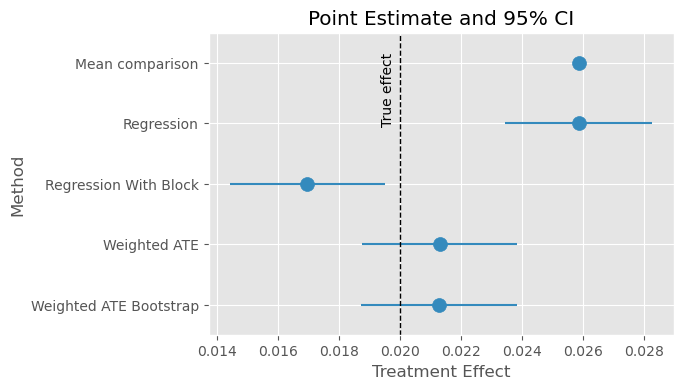

In [30]:
# Create forest plot
fig, ax = plt.subplots(dpi=100)

# Plot the large points with error bars
consolidated_result.plot.scatter(x='eff', y='method', xerr='half_ci', ax=ax, s=100)

# Set the y-axis limit and label
ax.set_ylim([-0.5, len(consolidated_result) - 0.5])
ax.set_yticks(range(len(consolidated_result)))
ax.set_yticklabels(consolidated_result['method'])

# Add a dashed line at y=0.02
ax.axvline(x=0.02, color='black', linewidth=1, linestyle='--')

# Add text along the vertical line
ax.text(0.0196, 3, 'True effect', ha='center', rotation='vertical')

# Set labels and title
plt.title('Point Estimate and 95% CI')
ax.set_xlabel('Treatment Effect')
ax.set_ylabel('Method')

# Show the plot
plt.show()

Estimates of the treatment effect in a simulated uplift campaign with varying Test to Control sample size ratio. Only the Confidence Interval of the Weighted Average Treatment Effect (Weighted ATE) includes the true effect (vertical dashed line).